# GradCam Visualization

## Loading Data

In [1]:
import torch
from torch import nn
from torch.utils import data
from torchvision import transforms, datasets, models
import json

import matplotlib.pyplot as plt
import numpy as np
import math

import plotly.io as pio
pio.renderers.default = "png"
from PIL import Image as PilImage
from omnixai.data.image import Image
from omnixai.explainers.vision.specific.gradcam.pytorch.gradcam import GradCAM

C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [7]:
test_root_dir= './../../data_processed/test'
model_path = './../../DenseNet-169_pretrained_GV_Dataset/checkpoints_30_32_0001/C_30_16.pth'  

In [8]:
n_classes=2  # number of classes used for training
batch_size=32

In [9]:
####################################
# Training
####################################

trans={    
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]),
}

In [10]:
###########################
# Checking if GPU is used
###########################

use_cuda=torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()
device=torch.device("cuda:0" if use_cuda else "mps" if use_mps else "cpu")
device = "cpu" 
device

'cpu'

In [11]:
#Initialize model
print('Best model path:{}'.format(model_path))
denseNet_model= models.densenet169(weights=False).to(device)

n_inputs = denseNet_model.classifier.in_features
denseNet_model.classifier = nn.Sequential(
              nn.Linear(n_inputs, n_classes),               
              nn.LogSoftmax(dim=1))

checkpoint=torch.load(model_path,map_location=device)   # loading best model
# change name of model dictionary key as per your model key defined while saving the model.
denseNet_model.load_state_dict(checkpoint['model_state_dict'])
denseNet_model.to(device)

Best model path:./../../DenseNet-169_pretrained_GV_Dataset/checkpoints_30_32_0001/C_30_16.pth


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [12]:
#Test Data Generator
test_dataset= datasets.ImageFolder(test_root_dir,transform=trans['test'])
test_generator=data.DataLoader(test_dataset,batch_size, shuffle=True)
print('Number of Test set images:{}'.format(len(test_dataset)))

Number of Test set images:443


In [13]:
class_names = test_dataset.classes
print("Total Classes: ", len(class_names))
print(class_names)

Total Classes:  2
['esca', 'healthy']


## Data Visualization

In [54]:
def get_class_unique_instances(data_loader):
        # Create a dictionary to store one instance per class
    class_instances = {}

    # Iterate through the DataLoader to find one instance from each class
    for images, labels in data_loader:
        for image, label in zip(images, labels):
            if label not in list(class_instances.keys()):
                class_instances[label] = image

    return class_instances


def truncate_title(title, max_length=30):
    if len(title) > max_length:
        return title[:max_length - 3] + "..."
    return title

# Function to plot one instance from each class
def plot_one_instance_per_class(class_instances, class_names):
    # Plot the images
    num_classes = len(list(class_instances.keys()))
    print("Classes computation completed found classes: ", num_classes)
    print("Plotting your classes...")
    
    # Calculate the number of rows and columns
    num_rows = 1
    num_cols = num_classes
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))

    count = 0
    images = list(class_instances.values())
    for i in range(num_rows):
        for j in range(num_cols):
            if count >= num_classes:
                fig.delaxes(axes[i][j])
                continue
            # Assuming images are normalized tensors
            single_image = images[count].permute(1, 2, 0).numpy()
            count += 1

            axes[j].imshow(single_image)
            axes[j].axis('off')
            class_label = i * num_cols + j
            class_title = truncate_title(class_names[class_label])
            axes[j].set_title(f'{class_title}' if class_label < num_classes else '')

    plt.show()
    


In [55]:
unique_instances = get_class_unique_instances(test_generator)
len(unique_instances.keys())

2

Classes computation completed found classes:  2
Plotting your classes...


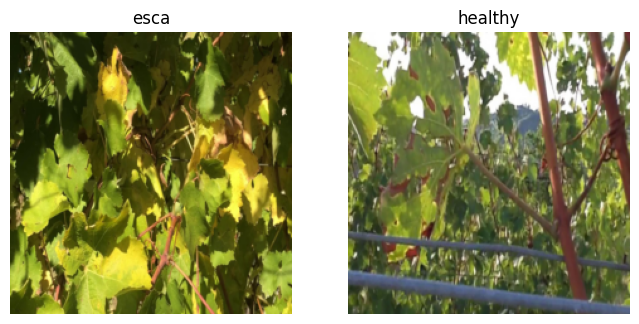

In [56]:
# Assuming your DataLoader is named 'data_loader'
plot_one_instance_per_class(unique_instances, class_names)

## Implementing GradCam

In [57]:
batch = next(iter(test_generator))
images, labels = batch

tensor_images = torch.stack(list(unique_instances.values()))
tensor_labels = torch.stack(list(unique_instances.keys()))

# background = images[:3]
# test_images = images[29:32]
# test_labels = labels[29:32]
background = tensor_images
test_images = tensor_images
test_labels = tensor_labels

In [58]:
denseNet_model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [59]:
denseNet_model.features.denseblock4

_DenseBlock(
  (denselayer1): _DenseLayer(
    (norm1): BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv1): Conv2d(640, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (denselayer2): _DenseLayer(
    (norm1): BatchNorm2d(672, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv1): Conv2d(672, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (denselayer3): _DenseLayer(
    (norm1): BatchNorm2d(704, eps=1e-05, moment

## Loading all images to Pytorch PIL Image

In [32]:
imgs = []
for img in tensor_images:
    imgs.append(np.array(transforms.ToPILImage()(img)))

# pil_img = np.array([, np.array(transforms.ToPILImage()(tensor_images[1]))])
imgs = np.array(imgs)
imgs.shape

(2, 224, 224, 3)

In [33]:
imgs = Image(np.array(imgs), batched=True, channel_last=True)

In [34]:
preprocess = lambda ims: torch.stack([trans['test'](im.to_pil()) for im in ims])

### Visualizing Features

In [35]:
explainer = GradCAM(
    model=denseNet_model,
    target_layer=denseNet_model.features,
    preprocess_function=preprocess,
    mode="classification"
)
# Explain the top label
explanations = explainer.explain(imgs)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


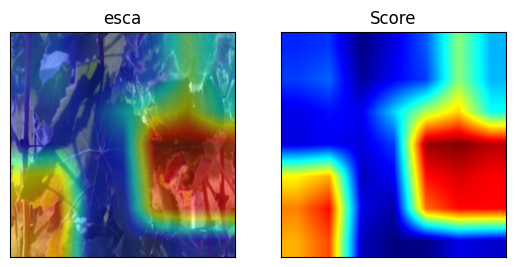

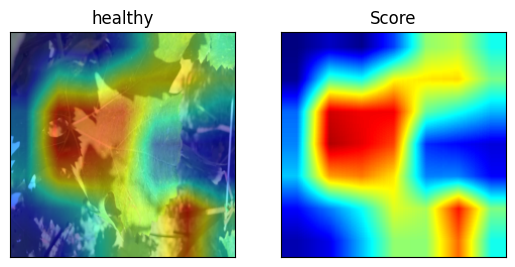

In [36]:
class_labels = [truncate_title(i, 20) for i in class_names]
fig = explanations.plot(class_names=class_labels)

### Visualize Block 1

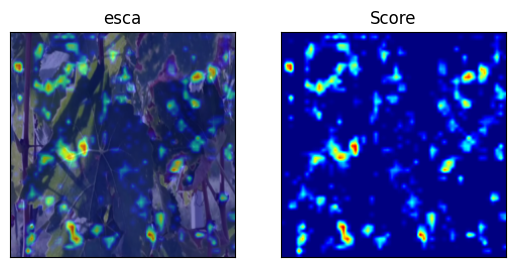

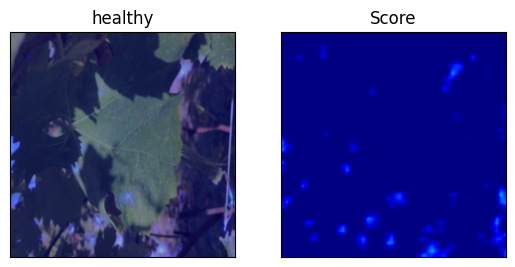

In [37]:
explainer = GradCAM(
    model=denseNet_model,
    target_layer=denseNet_model.features.denseblock1,
    preprocess_function=preprocess,
    mode="classification"
)
# Explain the top label
explanations = explainer.explain(imgs)

class_labels = [truncate_title(i, 20) for i in class_names]
fig = explanations.plot(class_names=class_labels)

### Visualize Block 2

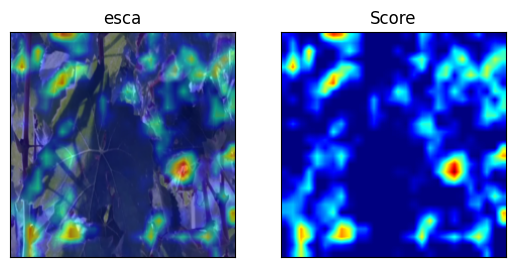

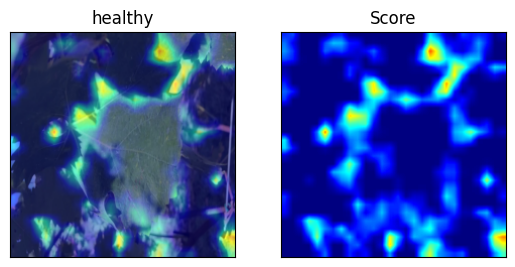

In [38]:
explainer = GradCAM(
    model=denseNet_model,
    target_layer=denseNet_model.features.denseblock2,
    preprocess_function=preprocess,
    mode="classification"
)
# Explain the top label
explanations = explainer.explain(imgs)

class_labels = [truncate_title(i, 20) for i in class_names]
fig = explanations.plot(class_names=class_labels)

### Visualize Block 3

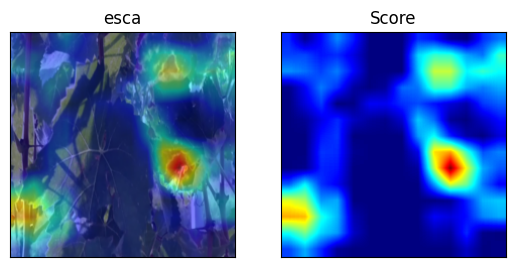

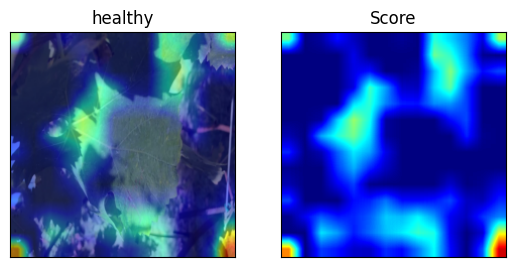

In [39]:
explainer = GradCAM(
    model=denseNet_model,
    target_layer=denseNet_model.features.denseblock3,
    preprocess_function=preprocess,
    mode="classification"
)
# Explain the top label
explanations = explainer.explain(imgs)

class_labels = [truncate_title(i, 20) for i in class_names]
fig = explanations.plot(class_names=class_labels)

### Visualize Block 4

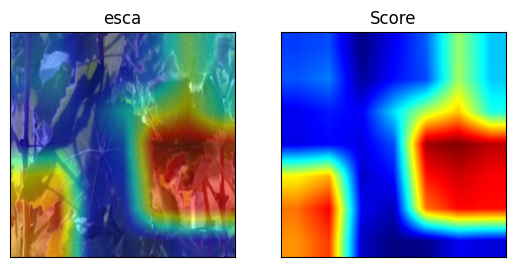

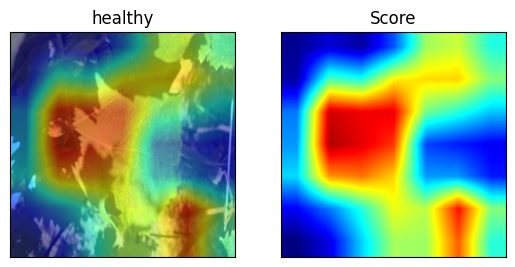

In [40]:
explainer = GradCAM(
    model=denseNet_model,
    target_layer=denseNet_model.features.denseblock4,
    preprocess_function=preprocess,
    mode="classification"
)
# Explain the top label
explanations = explainer.explain(imgs)

class_labels = [truncate_title(i, 20) for i in class_names]
fig = explanations.plot(class_names=class_labels)

In [41]:
ex = explanations.get_explanations(None)
ex[0].keys()

dict_keys(['image', 'scores', 'target_label'])

In [42]:
class_names[ex[0]['target_label']]

'esca'

Classes computation completed found classes:  2
Plotting your classes...


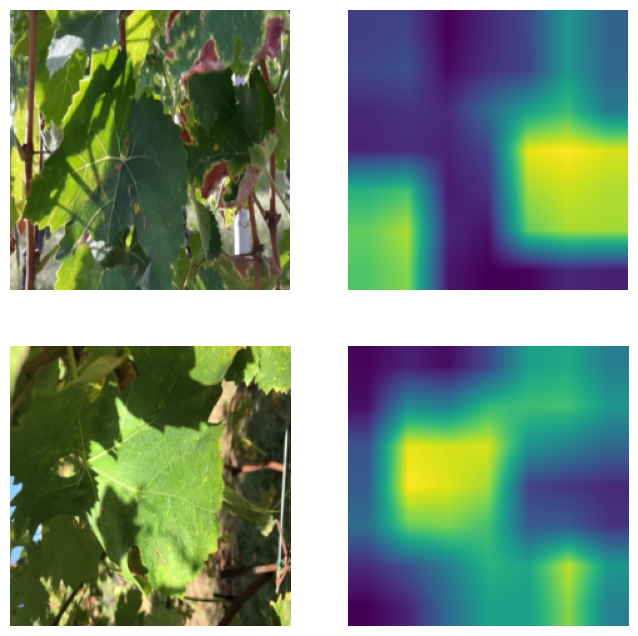

In [43]:
data = ex

def rescale(im):
    min_val, max_val = np.min(im), np.max(im)
    im = (im - min_val) / (max_val - min_val + 1e-8) * 255
    if im.ndim == 2:
        im = np.tile(np.expand_dims(im, axis=-1), (1, 1, 3))
    return im.astype(np.uint8)

# Function to plot one instance from each class
def plot_grad_results(data):
    # Plot the images
    num_classes = len(data)
    print("Classes computation completed found classes: ", num_classes)
    print("Plotting your classes...")
    
    # Calculate the number of rows and columns
    num_rows = num_classes
    num_cols = 2
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows), squeeze=False)

    count = 0
    for i, item in enumerate(data):
        # Assuming images are normalized tensors
        image = item['image']
#         score = np.abs(rescale(item["scores"]) - item["image"])
        score = item['scores']
        axes[i, 0].imshow(image)
        axes[i, 0].axis('off')
        axes[i, 1].imshow(score)
        axes[i, 1].axis('off')
        
#         class_title = truncate_title(class_names[class_label])
#         axes[i, j].set_title(f'{class_title}' if class_label < num_classes else '')

    plt.show()

# Plot all images in the data array
plot_grad_results(data)

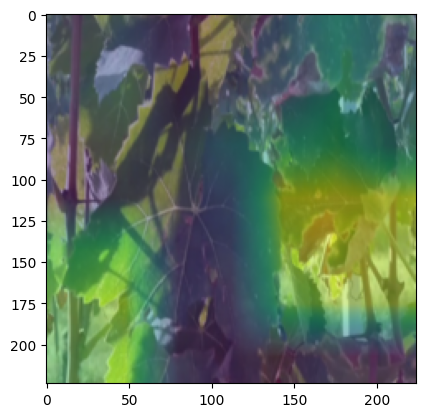

In [44]:
# np.vstack([ex[0]['image'], ex[0]['scores']])

array1 = ex[0]['image']
array2 = ex[0]['scores']

array2_normalized = (array2 - array2.min()) / (array2.max() - array2.min())

# Create a figure and axis
fig, ax = plt.subplots()

# Display array1 as an image
ax.imshow(array1)

# Overlay the heatmap (array2_normalized) on array1
heatmap = ax.imshow(array2_normalized, cmap='viridis', alpha=0.5)  # Adjust alpha for transparency

# Add colorbar to show the mapping of values to colors
# cbar = plt.colorbar(heatmap)

plt.show()